# Correlations: overlapping and non-overlapping
How bad is the overlapping calculations?

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yahoo_finance_pynterface as yahoo

In [2]:
hist_period = ['1950-01-01', '2019-04-12']
names = {'IBM', 'MSFT','KO', 'K', 'BCS', 'HSBC'}
kw_df_prices = {n:yahoo.Get.Prices(n, period=hist_period) for n in names}

In [3]:
val_col = 'Adj Close'

In [4]:
def ts_plot(name):
    kw_df_prices[name][val_col].iplot(title=name)

# Select a pair

<Figure size 432x288 with 0 Axes>

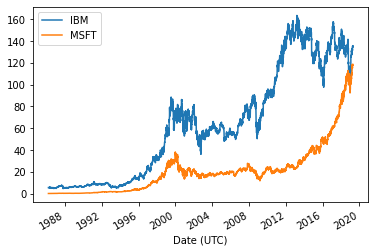

In [5]:
name_pair=['IBM','MSFT']
df_p = pd.DataFrame(data={n:kw_df_prices[n][val_col] for n in name_pair})
df_p = df_p.dropna()
plt.figure()
df_p.plot()
plt.show()

# Calculation Rolling Correlations
For a given horizon $h$, calculate rolling correlations in two different ways. Suppose that there are $M$ days in a rolling window. 
- overlapping: use $M$ changes 
- non-overlapping: use $M/h$ changes

In [6]:
# calculate correlation over a set of horizons
def calc_corr(df, dc_h2n, non_overlap=True):
    # dictionary of correlation by horizon
    dc_c_h = {}
    for h in dc_h2n:
        num_hors = dc_h2n[h]
        df_d = df.diff(h).dropna()

        # number of row
        n_d = df_d.shape[0]
        dc_c = {}

        for start_idx in range(0, n_d):

            if non_overlap:
                idx = start_idx + h * np.arange(0, num_hors)
            else:
                idx = start_idx + np.arange(0, h*num_hors)
                
            if(idx[-1] >= n_d):
                break

            df_d_novlp = df_d.iloc[idx] # non-overlapping diffs
            dt_end = df_d_novlp.index[-1]
            dc_c[dt_end] = df_d_novlp.corr().iloc[0,1]

        dc_c_h[h] = dc_c

    df_c = pd.DataFrame(data=dc_c_h)
    return df_c

## Setup
- set the calibration period (denoted by corr_period)
- set a set of pairs (h, n)
where
- h: horizon
- n: num of non-overlapping returns in the calibration period

In [7]:
corr_period = 240 * 10 # 240 * (number of year)
dc_h2n = {h:int(corr_period/h+0.01) for h in [1, 10, 20, 60, 120, 240]} 

## Run

In [8]:
# run: this can take time
df_c_no = calc_corr(np.log(df_p), dc_h2n, True)
df_c_ov = calc_corr(np.log(df_p), dc_h2n, False)

# collect
df_c_no.columns = ['non-overlap:' + str(c) for c in df_c_no.columns]
df_c_ov.columns = ['overlap:' + str(c) for c in df_c_ov.columns]
df_c = pd.concat([df_c_no, df_c_ov], axis = 1)

## Plots

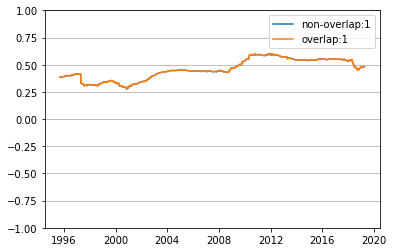

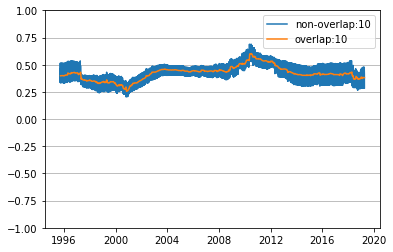

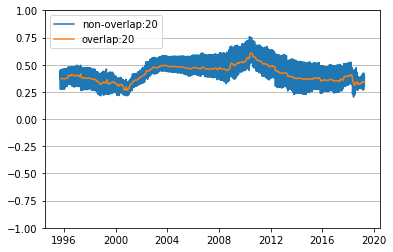

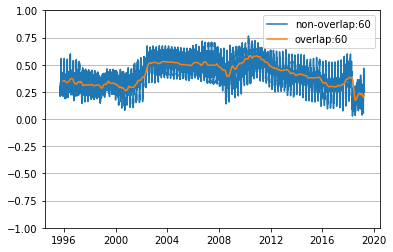

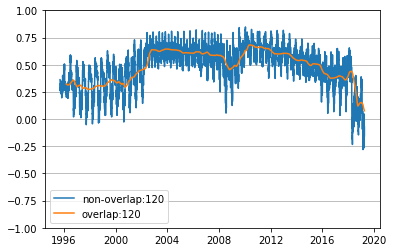

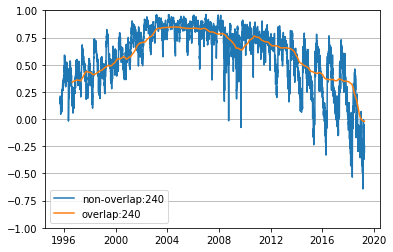

In [9]:
ylim = [-1, 1]
for h in dc_h2n:
    plt.figure()
    df_p = df_c[['non-overlap:' + str(h), 'overlap:' + str(h)]]
    for c in df_p.columns:
        plt.plot(df_p.index, df_p[c], label=c)
    plt.legend()
    plt.ylim(ylim)
    plt.grid(axis='y')
    plt.show()

# END